<a href="https://colab.research.google.com/github/HyperGlitch24/AMAI/blob/main/Active_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tutorial 6: Active Learning

In this tutorial, we will explore the principles of Active Learning, focusing specifically on various query functions used to select the most informative samples from an unlabeled dataset. We will begin by training a model on a small initial training set of 100 samples, then incrementally add more samples using different query strategies. Each time we expand the training set, the model will be retrained from scratch. Unlike traditional approaches, we will demonstrate that Active Learning can achieve comparable performance using significantly less labeled data.

The four query functions that we will learn about:
- Entropy query
- Best vs 2nd Best query
- Low confidence
- Monte-carlo sampling

In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

### Data Loading

We will use Cifar-10 in this notebook. The code to download is also provided !!

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR-10 Dataset
full_train = torchvision.datasets.CIFAR10(root='/app/src/data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='/app/src/data', train=False, download=True, transform=transform)

### Model Definition

1. Use a simple CNN or a predefined ResNet Architecture from torch
2. Make sure to use dropout which will help to implement the Monte-carlo sampling

In [12]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ''' TO-DO: Define the CNN architecture '''
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 32, 32] -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [B, 32, 16, 16]
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [B, 64, 8, 8]
            nn.Dropout(0.5)

        )

        self.fc = nn.Sequential(
            nn.Flatten(),                                # -> [B, 64*8*8]
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  # CIFAR-10: 10 classes
        )

        #self.dropout = torch.nn.Dropout(0.5)


    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        return x

from torchvision.models import resnet18
# Train Function
def train(model, dataloader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# Evaluate Function
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


### Train a baseline model for reference on the entire dataset

In [13]:
model = SimpleCNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
dataloader = DataLoader(full_train, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)

# Training Loop
for epoch in range(30):
    train(model, dataloader, optimizer)
    accuracy = evaluate(model, test_loader)
    scheduler.step()
    print(f'Epoch {epoch + 1}, Accuracy: {accuracy:.4f}')

Epoch 1, Accuracy: 0.4521
Epoch 2, Accuracy: 0.4273
Epoch 3, Accuracy: 0.5702
Epoch 4, Accuracy: 0.5980
Epoch 5, Accuracy: 0.6032
Epoch 6, Accuracy: 0.6277
Epoch 7, Accuracy: 0.6269
Epoch 8, Accuracy: 0.6489
Epoch 9, Accuracy: 0.6601
Epoch 10, Accuracy: 0.6441
Epoch 11, Accuracy: 0.6594
Epoch 12, Accuracy: 0.6742
Epoch 13, Accuracy: 0.6535
Epoch 14, Accuracy: 0.6710
Epoch 15, Accuracy: 0.6969
Epoch 16, Accuracy: 0.7046
Epoch 17, Accuracy: 0.7057
Epoch 18, Accuracy: 0.7048
Epoch 19, Accuracy: 0.7168
Epoch 20, Accuracy: 0.7178
Epoch 21, Accuracy: 0.7141
Epoch 22, Accuracy: 0.7264
Epoch 23, Accuracy: 0.7269
Epoch 24, Accuracy: 0.7295
Epoch 25, Accuracy: 0.7339
Epoch 26, Accuracy: 0.7377
Epoch 27, Accuracy: 0.7355
Epoch 28, Accuracy: 0.7397
Epoch 29, Accuracy: 0.7421
Epoch 30, Accuracy: 0.7412


### Query Sampler function


Define the following query function methods under the QuerySampler class

1. Entropy Query
2. Best vs 2nd Best Query function
3. Lowest confidence query
4. Monte-Carlo Sampling



In [ ]:
from tqdm import tqdm
class QuerySampler:
    def __init__(self, n_samples):
        #self.model = model
        #self.unlabeled_loader = unlabeled_loader
        self.n_samples = n_samples

    def entropy_query(self,model, unlabeled_loader):
        model.eval()
        ''' Calculate entropy for each sample in the unlabeled dataset and return indices of the top uncertain samples '''
        return [all_indices[i] for i in top_indices]

    def enable_dropout(self,model):
        for m in model.modules():
            if isinstance(m, nn.Dropout):
                m.train()
    def montecarlo_sampling(self, model, unlabeled_loader):
        model.eval()
        self.enable_dropout(model)

        all_probs = []
        with torch.no_grad():
            ''' Perform multiple forward passes to get predictions with dropout enabled for MonteCarlo sampling
                and calculate entropy for each sample over the mean of the predictions'''
        return topk_indices #entropy.numpy()
    def least_confidence_query(self, model, unlabeled_loader):
        model.eval()
        ''' Calculate least confidence for each sample in the unlabeled dataset and return indices of the top uncertain samples '''



        return [all_indices[i] for i in top_indices]

    def BVB_query(self, model, unlabeled_loader):
        model.eval()
        ''' Compare the top two predictions for each sample in the unlabeled dataset and return indices of the top uncertain samples '''
        return [all_indices[i] for i in top_indices]




# Initial Split
INITIAL_SIZE = 100
BATCH_SIZE = 32
QUERY_SIZE = 1500
EPOCHS = 25
ITERATIONS = 20

query = QuerySampler(QUERY_SIZE)


### Train your model with Active Query

1. Split the dataset into labeled and unlabeled set. Set the initial labeled set to 100 for example.
2. Train the model to convergence with the intial labeled set
3. Now use the unlabeled dataset to choose N samples using active query functions
4. Combine the initial labeled set with the choosen sample
5. Train the model from scratch
6. Repeat until you reach the baseline performance

In [ ]:
labeled_indices = np.random.choice(len(full_train), INITIAL_SIZE, replace=False).tolist()
unlabeled_indices = list(set(range(len(full_train))) - set(labeled_indices))
total_acc = []
for iteration in range(ITERATIONS):
    print(f"\n--- Iteration {iteration + 1} ---")
    ''' Create labeled and unlabeled datasets based on the current indices
     And train the model on multiple iterations of Active query learning '''

### Visualize performance of the model across all the query functions  

/tmp/ipykernel_8142/1601215045.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load('/app/src/cifar10_lcnfidence.pth')


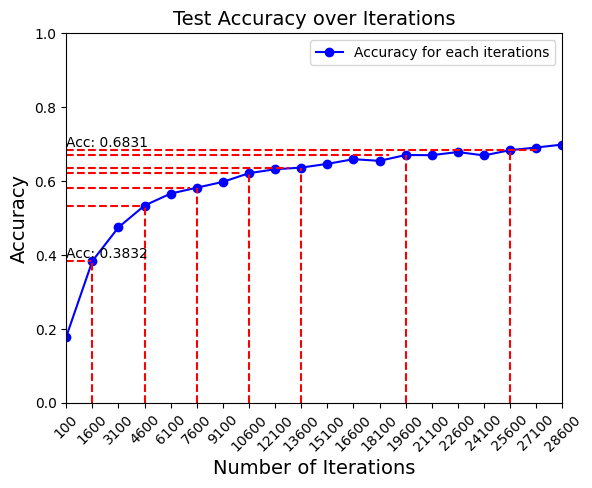

In [ ]:
import torch
import matplotlib.pyplot as plt
 ''' Plotting the accuracy over iterations '''

plt.legend()
plt.show()

### Active Learning with Corrupted Cifar-10

Now that we have seen how different query functions help in selecting more informative samples, we will make the training conditions more challenging by introducing corrupted samples alongside the clean ones. Specifically, we will use the Corrupted CIFAR-10 dataset mixed with the standard CIFAR-10 dataset. The goal is to evaluate whether the query functions can effectively prioritize clean CIFAR-10 samples while ignoring the corrupted ones. Begin by downloading the Corrupted CIFAR-10 dataset, which includes various types of corruptions. Choose one or more corruption types to combine with the clean CIFAR-10 data for this experiment.

Then, we will similarily train the models using the four query functions.

First, Download the corrupted Cifar-10: https://zenodo.org/records/2535967

In [ ]:
import tarfile

tar_path = "/app/src/CIFAR-10-C.tar"
extract_path = "/app/src/"

with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_path)

In [ ]:
import numpy as np
file = np.load('/app/src/CIFAR-10-C/brightness.npy')
file.shape

(50000, 32, 32, 3)

### Combine the corrupted samples with the clean instances

In [ ]:
full_train.data = np.concatenate([full_train.data, file])
full_train.data.shape
full_train.targets = full_train.targets + full_train.targets
len(full_train.targets)
labeled_indices = np.random.choice(50000, INITIAL_SIZE, replace=False).tolist()
unlabeled_indices = list(set(range(len(full_train))) - set(labeled_indices))

### Test the different query functions with corrupted Cifar-10

In [ ]:
from tqdm import tqdm

''' Call or define QuerySampler class here'''




# Initial Split
INITIAL_SIZE = 100
BATCH_SIZE = 32
QUERY_SIZE = 1500
EPOCHS = 25
ITERATIONS = 20

query = QuerySampler(QUERY_SIZE)
#labeled_indices = np.random.choice(len(full_train), INITIAL_SIZE, replace=False).tolist()
#unlabeled_indices = list(set(range(len(full_train))) - set(labeled_indices))
total_acc = []
for iteration in range(ITERATIONS):
''' Train the model on multiple iterations of Active query learning on CIFAR-10-C dataset '''


### Investigate the performance of the query functions

You have probably found out that the model doesn't achieve the similar performance by adding some corrupted samples.
Now, let us investigate what type of samples are selected by the different query functions.

1. Compare the number of clean samples selected by the query functions
2. Compare the number of corrupted samples selected by the query functions
3. Try to experiment with the hyperparameters such as the initial number of labeled samples and see whether it makes the difference or not.

Visualize the findings !!


In [ ]:
## To-do ###
